In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

import os
import sys
import numpy as np
from glob import glob
import dataflow
import numpy as np
import zstandard as zstd
import msgpack
import msgpack_numpy
msgpack_numpy.patch()

from tqdm.notebook import trange, tqdm
from rbfNet import *

from plotting import *
plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm
decompressor = zstd.ZstdDecompressor()


In [182]:
from rbfNet import *

In [255]:

class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, activation = 'relu',
                coordinateMapping = 'polar', n = 8, m = 8, windowFn = None, rbf_x = 'linear', rbf_y = 'linear', batchSize = 32, ignoreCenter = False):
        super().__init__()
        self.centerIgnore = ignoreCenter
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = self.features[0],
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y],
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = activation,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = self.features[0],
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y],
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = activation,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=False))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)

        self.features[0] = self.features[0]
#         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
        for i, l in enumerate(layers[1:-1]):
#             debugPrint(layers[i])
#             debugPrint(layers[i+1])
            self.convs.append(RbfConv(
                in_channels = (3 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
                dim = 2, size = [n,m],
                rbf = [rbf_x, rbf_y],
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
            self.fcs.append(nn.Linear(in_features=3 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=False))
            torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
            
        self.convs.append(RbfConv(
            in_channels = self.features[-2], out_channels = self.features[-1],
                dim = 2, size = [n,m],
                rbf = [rbf_x, rbf_y],
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        self.fcs.append(nn.Linear(in_features=layers[-2],out_features=self.features[-1],bias=False))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)


    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                attributes, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        if self.centerIgnore:
            nequals = fi != fj

        i, ni = torch.unique(fi, return_counts = True)
        b, nb = torch.unique(bf, return_counts = True)
        ni[i[b]] += nb
        self.li = torch.exp(-1 / np.float32(attributes['targetNeighbors']) * ni)
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/attributes['support']
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
        if self.centerIgnore:
            fluidEdgeIndex = torch.stack([fi[nequals], fj[nequals]], dim = 0)
        else:
            fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/attributes['support']
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
#         if verbose:
#             print('prepared network with inputs:')
#             print('fluidPositions', fluidPositions[:4])
#             print('fluidFeatures', fluidFeatures[:4])
#             print('boundaryPositions', boundaryPositions[:4])
#             print('boundaryFeatures', boundaryFeatures[:4])
#             print('fluid neighbors:', fluidEdgeIndex.shape)
#             print('fluid neighbor distances', fluidEdgeLengths[:4])
#             print('boundary neighbors:', boundaryEdgeIndex.shape)
#             print('boundary neighbor distances', boundaryEdgeLengths[:4])
#             print('num neighbors', ni[:4])
#             print('li', self.li[:4])
            
            
        linearOutput = self.relu(self.fcs[0](fluidFeatures))
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
        ans = torch.hstack((linearOutput, fluidConvolution, boundaryConvolution))
        if verbose:
#             print('linear output', linearOutput[:4])
#             print('boundary convolution output', boundaryConvolution[:4])
#             print('fluid convolution output', fluidConvolution[:4])
            print('first layer output', ans[:4])
        
        layers = len(self.convs)
        for i in range(2,layers):
            ansConv = self.convs[i]((ans, ans), fluidEdgeIndex, fluidEdgeLengths)
            ansDense = self.fcs[i - 1](ans)
            
            
            if self.features[i-2] == self.features[i-1] and ans.shape == ansConv.shape:
                ans = ansConv #+ ansDense + ans
            else:
                ans = ansConv #+ ansDense
#             if verbose:
#                 print('\tlayer', i)
#                 print('\tlinear output', ansDense[:4])
#                 print('\tfluid convolution output', ansConv[:4])
#                 print('\tlayer output', ans[:4])
                
            if i != layers - 1:
                ans = self.relu(ans)
            if verbose:
                print('\tlayer output after activation', ans[:4])
        return ans
            

In [256]:
extension = '.hdf5'

basePath = os.path.expanduser('~/dev/datasets/WBCSPH2Dc')
trainFiles = glob(os.path.join(os.path.join(basePath, 'train'), '*' + extension))
validFiles = glob(os.path.join(os.path.join(basePath, 'valid'), '*' + extension))
testFiles = glob(os.path.join(os.path.join(basePath, 'test'), '*' + extension))

# print(trainFiles)
# print(validFiles)
# print(testFiles)

simulationFiles = sorted(trainFiles + validFiles + testFiles)
simulationFiles = ['/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0043.hdf5']

simFiles = ['/'.join(s.split('/')[-2:]) for s in simulationFiles]
debugPrint(simFiles)


simFiles [list] = ['train/sim_0043.hdf5']


In [257]:
networkPath = '~/dev/pytorchSPH2/Cconv/trainingData/cconvlike - n=[ 4, 4] rbf=[linear,linear] map = preserving window = Spiky d =  1 e = 25 distance =  1 - 2023-03-01_14-14-19'

In [293]:

def loadRbfModel(file, frame, networkPath, epoch):
    with open(os.path.expanduser("%s/results.json" % networkPath), "r") as read_file:
        decodedArray = json.load(read_file)
        dataDict = decodedArray
    
    n = dataDict['hyperParameters']['n']
    m = dataDict['hyperParameters']['m']
    coordinateMapping = dataDict['hyperParameters']['coordinateMapping']
    windowFn = getWindowFunction(dataDict['hyperParameters']['windowFunction'])
    rbf_x = dataDict['hyperParameters']['rbf_x']
    rbf_y = dataDict['hyperParameters']['rbf_y']
    dist = dataDict['hyperParameters']['frameDistance']
    unroll = dataDict['hyperParameters']['maxRollOut']
    arch = [32, 64, 64, 2]
    arch = [16, 32, 32, 2]
    arch = dataDict['hyperParameters']['arch']
    print(arch)

    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(unroll), dist)
    inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
    
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
    
    model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32)
    model.load_state_dict(torch.load(os.path.expanduser('%s/model_%03d.torch' % (networkPath, epoch))))
    model = model.to(device)
    model.train(False)
    return model


In [294]:
def getRbfNetworkParams(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)    
    return inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device)
def computeRbfNetworkLoss(predictedPosition, predictedVelocity, groundTruth, modelOutput):
    posLoss = torch.sqrt(torch.linalg.norm(groundTruth[:,:2] - predictedPosition, dim = 1))
    return posLoss
    velLoss = torch.sqrt(torch.linalg.norm(groundTruth[:,2:4] - predictedVelocity, dim = 1))
    return posLoss + velLoss    
def runRbfNetwork(initialPosition, initialVelocity, dt, frameDistance, params, gt, computeLoss = False, li = True):
    d = (frameDistance) * ((frameDistance) + 1) / 2
    gravity, fluidFeatures, boundaryPositions, boundaryFeatures = params   
    
    vel2 = initialVelocity + frameDistance * dt * gravity
    pos2 = initialPosition + frameDistance * dt * initialVelocity + d * dt**2 * gravity
    
    fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], vel2, fluidFeatures[:,3:]))
    predictions = model(pos2, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, None, None)

    predictedVelocity = (pos2 + predictions - initialPosition) / (frameDistance * attributes['dt'])
    predictedPositions = pos2 + predictions[:,:2]
    if computeLoss:        
        if li:
            loss = model.li * computeRbfNetworkLoss(predictedPositions, predictedVelocity, torch.hstack(gt), predictions)
        else:
            loss = computeRbfNetworkLoss(predictedPositions, predictedVelocity, torch.hstack(gt), predictions)

        return predictedPositions, predictedVelocity, loss
    else:
        return predictedPositions, predictedVelocity


In [295]:
def getGroundTruth(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    return inputData['fluidPosition'].to(device), inputData['fluidVelocity'].to(device)

In [296]:
model = loadRbfModel(simulationFiles[0],0, networkPath, 1)


[32, 64, 64, 2]


In [297]:
frameIndex = 100
    
params = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, frameIndex + np.arange(1))
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

In [298]:
predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']

# groundTruth

In [299]:
# runNetwork(fluidPositions.to(device), inputData['fluidVelocity'].to(device), attributes['dt'], 1, inputData['fluidGravity'][:,:2].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device), groundTruthData[0], model, None, None, True)

In [300]:
predictedPositions, predictedVelocities = runRbfNetwork(predictedPositions, predictedVelocities, dt, 1, params, gt, False)

In [5]:
batch_size = 4

# train_ds = datasetLoader(training)
# train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler

# validation_ds = datasetLoader(validation)
# validation_dataloader = DataLoader(validation_ds, shuffle=True, batch_size = batch_size).batch_sampler

fileName, frameIndex, maxRollout = simulationFiles[0], 0, 2
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

debugPrint(fluidFeatures.shape)


n = 5
m = 5
coordinateMapping = 'preserving'
windowFunction = 'poly6'
# windowFunction = 'None'
windowFn = getWindowFunction(windowFunction)
rbf_x = 'linear'
rbf_y = 'linear'
initialLR = 1e-3
maxRollOut = 10
epochs = 25
activation = 'relu'
# activation = 'none'
frameDistance = 1
arch = [32, 64, 64, 2]
# arch = [4,4,4,4,4,4,2]
# arch = [8,8,8,2]
n = 4
m = 4
# arch = [2,8,8,2]
# arch = [2,2,2,2,2,2,2,2]

model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], layers = arch, coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 64)


lr = initialLR
optimizer = Adam(model.parameters(), lr=lr)
model = model.to(device)

# torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters', count_parameters(model))

# with torch.no_grad():
#     model.convs[0].weight[:] = torch.normal(mean = torch.ones(model.convs[0].weight.shape),  std = 1e-4)
#     model.convs[1].weight[:] = torch.normal(mean = torch.ones(model.convs[1].weight.shape),  std = 1e-4)

        
optimizer.zero_grad()
model.train()

hyperParameterDict = {}
hyperParameterDict['n'] = n
hyperParameterDict['m'] = m
hyperParameterDict['coordinateMapping'] = coordinateMapping
hyperParameterDict['rbf_x'] = rbf_x
hyperParameterDict['rbf_y'] = rbf_y
hyperParameterDict['windowFunction'] = 'yes' if windowFn is not None else 'no'
hyperParameterDict['initialLR'] = initialLR
hyperParameterDict['maxRollOut'] = maxRollOut
hyperParameterDict['epochs'] = epochs
hyperParameterDict['frameDistance'] = frameDistance
hyperParameterDict['parameters'] =  count_parameters(model)
dist = frameDistance
# debugPrint(hyperParameterDict)

print('Network Hyperparameters:')
print('[n x m]: [%dx%d]'% (n, m))
print('[rbf_x x rbf_y]: [%sx%s]'% (rbf_x, rbf_y))
print('Mapping:', coordinateMapping)
print('window function:', windowFunction)
print('activation function:', activation)
print('initial learning rate: ', initialLR)
print('Training for %d epochs' % epochs)
print('Rollout limit (if applicable):', maxRollout)
print('Training with frame offset of', frameDistance)
print('Network architecture', arch)


/home/winchenbach/dev/pytorchSPH2/Cconv/datautils.py:444: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/utils/tensor_numpy.cpp:172.)
  gravity =  torch.zeros_like(torch.from_numpy(data[frame]['vel'][:]).type(torch.float32))


fluidFeatures.shape [Size] = torch.Size([7062, 6])
Number of parameters 180544
Network Hyperparameters:
[n x m]: [4x4]
[rbf_x x rbf_y]: [linearxlinear]
Mapping: preserving
window function: poly6
activation function: relu
initial learning rate:  0.001
Training for 25 epochs
Rollout limit (if applicable): 2
Training with frame offset of 1
Network architecture [32, 64, 64, 2]


In [7]:
# fileName = simulationFiles[0]
# frameIndex = 0

# dist = 1

# attributes, inputData, groundTruths = loadFrame(fileName, frameIndex, 1 + np.arange(4), dist)
# fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)

simFiles [list] = ['train/sim_0000.msgpack.zst', 'train/sim_0002.msgpack.zst', 'train/sim_0003.msgpack.zst', 'train/sim_0004.msgpack.zst', 'train/sim_0005.msgpack.zst', 'train/sim_0006.msgpack.zst', 'train/sim_0007.msgpack.zst', 'train/sim_0010.msgpack.zst', 'train/sim_0012.msgpack.zst', 'train/sim_0013.msgpack.zst', 'train/sim_0014.msgpack.zst', 'train/sim_0016.msgpack.zst', 'train/sim_0018.msgpack.zst', 'train/sim_0019.msgpack.zst', 'train/sim_0020.msgpack.zst', 'train/sim_0021.msgpack.zst', 'train/sim_0022.msgpack.zst', 'train/sim_0023.msgpack.zst', 'train/sim_0024.msgpack.zst', 'train/sim_0026.msgpack.zst', 'train/sim_0028.msgpack.zst', 'train/sim_0029.msgpack.zst', 'train/sim_0030.msgpack.zst', 'train/sim_0031.msgpack.zst', 'train/sim_0032.msgpack.zst', 'train/sim_0033.msgpack.zst', 'train/sim_0034.msgpack.zst', 'train/sim_0036.msgpack.zst', 'train/sim_0039.msgpack.zst', 'train/sim_0040.msgpack.zst', 'train/sim_0043.msgpack.zst', 'train/sim_0045.msgpack.zst', 'train/sim_0046.msgpa

<IPython.core.display.Javascript object>


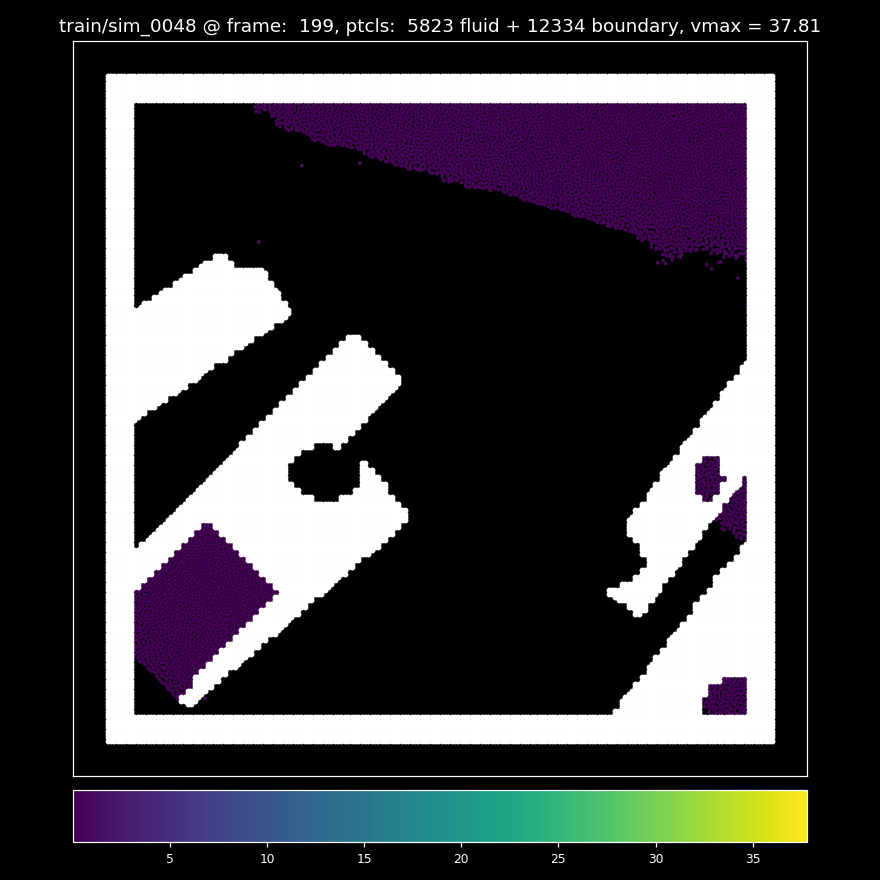

[-8.32406067 -8.32406067  0.        ]


interactive(children=(Dropdown(description='fileName', options=('train/sim_0000.msgpack.zst', 'train/sim_0002.…

<function __main__.plotNetwork(fileName, frame)>

In [128]:
# debugPrint(simulationFiles)

fig, axis = plt.subplots(1, 1, figsize=(8,8), sharex = False, sharey = False, squeeze = False)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

# v = (gt[:,-1:] - modelOutput) ** 2
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

# axis[0,0].set_title('Velocity')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
axis[0,0].axis('equal')
# axis[0,0].set_xlim(np.min(x) * 1.05, np.max())
axis[0,0].set_xlim(-0.05,1.05)
axis[0,0].set_ylim(-0.05,1.05)
# axis[0,1].axvline(-2)
# axis[0,1].axvline(2)
# axis[0,1].axhline(-2)
# axis[0,1].axhline(2)
bdyScatter = axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

# font3 = {'family':'cursive','color':'green','size':20}
# plt.title('. ', fontdic = font3)

axis[0,0].set_title('%s @ %2d' % (simulationFiles[0].split('/')[-1].split('.')[0], 0))
    
prevFile = None
prevFrame = None
def plotNetwork(fileName, frame):
    global prevFile, prevFrame   
    
    file = basePath + '/' + fileName
    
    if file != prevFile:
        frameSlider.max = getFrameCount(file) - 1
        frameSlider.value = 0
        frame = 0
        
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(0), 1)
        
    if file != prevFile:
        bdyScatter.set_offsets(inputData['boundaryPosition'][:,:2])
        prevFile = file
        
    if frame != prevFrame:
        prevFrame = frame
        
    
    
    
    
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
#     debugPrint(data.shape)
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    GTsc.set_offsets(positions)
    GTsc.set_array(data)
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    
    axis[0,0].set_title('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.canvas.draw()
    fig.canvas.flush_events()


def getFrameCount(file):
    if 'zst' in file:
        with open(os.path.expanduser(file), 'rb') as f:
            data = msgpack.unpackb(decompressor.decompress(f.read()), raw=False)
            
            print(data[0]['grav'])
            return len(data)
    if 'hdf5' in file:        
        inFile = h5py.File(file)
        length = len(inFile['simulationExport'].keys())
        print(inFile.attrs['fluidGravity'])
        inFile.close()
        return length
        
axis[0,0].set_xticks([], [])
axis[0,0].set_yticks([], [])
    
frameSlider = widgets.IntSlider(value=0, min=0, max=getFrameCount(simulationFiles[0]) - 1, step=1)

fig.tight_layout()

interact(plotNetwork, fileName = simFiles, frame = frameSlider)




In [106]:
import subprocess
import shlex

def createOutputs(simulationFile):
    file = basePath + '/' + simulationFile
    
    inFile = h5py.File(file, 'r')
    frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
    inFile.close()

    
    imageFolder = '../images/%s/' % simulationFile.split('.')[0].replace('/','_')
#     print(imageFolder)
#     break
    
    if not os.path.exists(imageFolder):
        os.makedirs(imageFolder)
        for i in tqdm(range(0, frameCount, 8), leave = False):
            plotNetwork(simulationFile, i)
            imagePath = '../images/%s/%04d.png' % (simulationFile.split('.')[0].replace('/','_'), i)
            plt.savefig(imagePath, dpi = 200)
#         print('converting to video')
        p = subprocess.Popen(shlex.split("/usr/bin/ffmpeg -y -hide_banner -loglevel error -framerate 50 -f image2 -pattern_type glob -i '*.png' -c:v libx264 -b:v 20M -r 50 out.mp4"), cwd='../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
#         print('Creating video gif')
        p = subprocess.Popen(shlex.split("/usr/bin/ffmpeg -y -hide_banner -loglevel error -i out.mp4 -filter_complex 'fps=50,scale=720:-1:flags=lanczos,split[s0][s1];[s0]palettegen=max_colors=32[p];[s1][p]paletteuse=dither=bayer' output.gif"), cwd='../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
#         print('Copying output')
        p = subprocess.Popen(shlex.split('cp output.gif ../%s.gif' % (simulationFile.split('.')[0].replace('/','_')).replace(' ','_')), cwd = '../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
    else:
        print('nothing to do for %s' % simulationFile)
    return
    

In [107]:
createOutputs('train/sim_0000.hdf5')

  0%|          | 0/400 [00:00<?, ?it/s]

In [86]:
frameCounts = []
fluidCounts = []
boundaryCounts = []

for s in tqdm(simulationFiles): 
    inFile = h5py.File(s)
    length = len(inFile['simulationExport'].keys())
    numFluids = inFile['simulationExport']['00000']['fluidPosition'].shape[0]
    numBoundary = inFile['boundaryInformation']['boundaryPosition'].shape[0]
    inFile.close()
    frameCounts.append(length)
    fluidCounts.append(numFluids)
    boundaryCounts.append(numBoundary)
    print('simulation %s has %4d frames, %5d fluid ptcls, %5d bdy ptcls'% (s.split('/')[-1].split('.')[0], length, numFluids, numBoundary))

  0%|          | 0/59 [00:00<?, ?it/s]

simulation sim_0006 has  300 frames,  1104 fluid ptcls,  6144 bdy ptcls
simulation sim_0024 has  300 frames,  7728 fluid ptcls,  6144 bdy ptcls
simulation sim_0049 has  200 frames, 16928 fluid ptcls,  6144 bdy ptcls
simulation sim_0060 has 3200 frames,  6034 fluid ptcls, 18326 bdy ptcls
simulation sim_0061 has 3200 frames,  2009 fluid ptcls, 18288 bdy ptcls
simulation sim_0062 has 3200 frames, 11259 fluid ptcls, 11948 bdy ptcls
simulation sim_0063 has 3200 frames,  8371 fluid ptcls, 13896 bdy ptcls
simulation sim_0065 has 3200 frames, 11530 fluid ptcls, 10863 bdy ptcls
simulation sim_0066 has 3200 frames, 13484 fluid ptcls, 15103 bdy ptcls
simulation sim_0067 has 3200 frames, 10824 fluid ptcls, 13261 bdy ptcls
simulation sim_0068 has 3200 frames,  8851 fluid ptcls, 11829 bdy ptcls
simulation sim_0069 has 3200 frames,  8864 fluid ptcls,  8579 bdy ptcls
simulation sim_0000 has 3200 frames,  7062 fluid ptcls, 16057 bdy ptcls
simulation sim_0002 has 3200 frames, 10494 fluid ptcls, 14447 bd

In [55]:
print(frameCounts)

[3200, 3200, 3200, 3200, 3200, 2000, 3200, 3200, 3200, 3200, 1200, 3200, 3200, 3200, 3200, 3200, 3200, 3200, 400, 3200, 3200, 1200, 3200, 3200, 3200, 3200, 3200, 3200, 3200, 3200, 3200, 3200, 3200, 3200, 1600]


In [44]:

length = len(inFile['simulationExport'].keys())
print(length)

3200


In [52]:
inFile.close()

In [ ]:

interact(plotNetwork, file = simulationFiles, frame = widgets.IntSlider(value=0, min=0, max=2000, step=1), networkPath = subfolders, epoch = widgets.IntSlider(value=epochs -1, min=0, max=epochs -1, step=1), )